In [13]:
# Install ultralytics if not present
import sys
import subprocess
def pip_install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

try:
    import ultralytics
except Exception:
    pip_install('ultralytics>=8.0.0')
    import ultralytics

print('ultralytics version:', ultralytics.__version__)

ultralytics version: 8.3.189


In [14]:
# Create dataset YAML file that ultralytics accepts
from pathlib import Path
root = Path('.').resolve()
dataset_dir = root / 'dataset'
images_dir = dataset_dir / 'images'
labels_dir = dataset_dir / 'labels'
yaml_path = root / 'dataset.yaml'

# Use repository root as the base 'path' to avoid duplicated path segments when ultralytics joins paths
# and set train/val/test as relative paths under that base.
data = {
    'path': str(root),
    'train': 'dataset/images/train',
    'val': 'dataset/images/val',
    'test': 'dataset/images/test',
}

# Infer class ids from label files and build 'nc' and 'names'
def gather_class_ids(labels_dir):
    ids = set()
    for split in ('train', 'val', 'test'):
        split_dir = labels_dir / split
        if not split_dir.exists():
            continue
        for f in split_dir.rglob('*.txt'):
            try:
                for line in f.read_text(encoding='utf-8').splitlines():
                    line = line.strip()
                    if not line:
                        continue
                    parts = line.split()
                    if len(parts) >= 1:
                        try:
                            cls = int(parts[0])
                            ids.add(cls)
                        except ValueError:
                            # non-integer class id found; skip
                            continue
            except Exception:
                continue
    return sorted(ids)

class_ids = gather_class_ids(labels_dir)
if class_ids:
    nc = max(class_ids) + 1
    # create default names: class0, class1, ... up to nc-1
    names = [f'class{i}' for i in range(nc)]
    data['nc'] = nc
    data['names'] = names
else:
    print('Warning: no class ids found in labels; please add "names" or "nc" to dataset.yaml manually if needed')

import yaml
with open(yaml_path, 'w', encoding='utf-8') as f:
    yaml.dump(data, f, sort_keys=False)

print('Wrote', yaml_path)
print('Detected class ids:', class_ids)
if 'nc' in data:
    print('Using nc=', data['nc'], 'and names sample:', data['names'][:10])

# Basic sanity checks that the computed dataset paths exist when joined with base 'path'
def check_paths(data):
    base = Path(data['path'])
    missing = []
    for k in ('train','val','test'):
        p = (base / Path(data[k])).resolve()
        if not p.exists():
            missing.append(str(p))
    return missing

missing = check_paths(data)
if missing:
    print('\nWARNING: The following dataset image paths were not found:')
    for m in missing:
        print(' -', m)
    print('\nIf paths look wrong, adjust `data["path"]` or the train/val/test entries in dataset.yaml.\n')
else:
    print('All dataset image paths exist.')


Wrote E:\Radio Waves\dataset.yaml
Detected class ids: [0]
Using nc= 1 and names sample: ['class0']
All dataset image paths exist.


1959 training images, 1959 label files


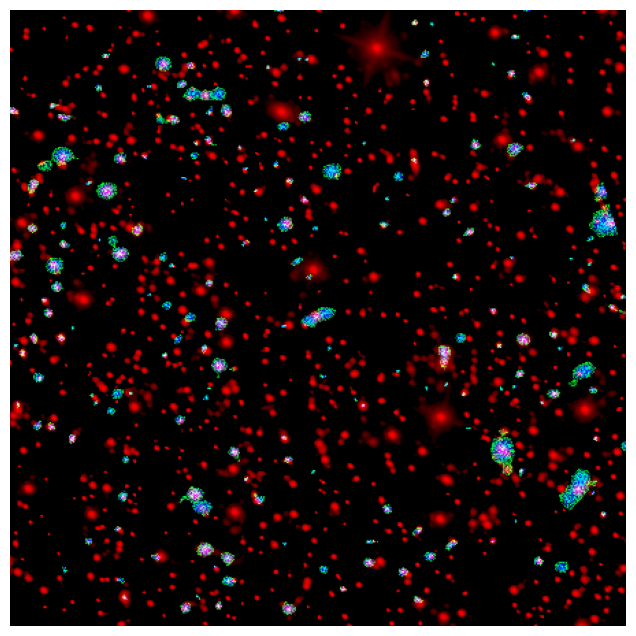

In [15]:
# Preview a few images with labels (YOLO txt format)
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
images_train = list((images_dir / 'train').glob('**/*.*'))
labels_train = list((labels_dir / 'train').glob('**/*.txt'))
print(f'{len(images_train)} training images, {len(labels_train)} label files')

def read_yolo_label(label_path):
    lines = label_path.read_text().strip().splitlines() if label_path.exists() else []
    boxes = []
    for ln in lines:
        parts = ln.split()
        if len(parts) >= 5:
            cls = int(parts[0])
            x_center, y_center, w, h = map(float, parts[1:5])
            boxes.append((cls, x_center, y_center, w, h))
    return boxes

def show_image_with_boxes(img_path, label_path):
    import PIL.Image as Image
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    fig,ax = plt.subplots(1,figsize=(8,8))
    ax.imshow(img)
    for cls,x_c,y_c,box_w,box_h in read_yolo_label(label_path):
        x1 = (x_c - box_w/2)*w
        y1 = (y_c - box_h/2)*h
        rect = patches.Rectangle((x1,y1), box_w*w, box_h*h,linewidth=2,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1-4, str(cls), color='yellow', fontsize=12, weight='bold')
    plt.axis('off')
    plt.show()

if images_train:
    idx = random.randrange(len(images_train))
    img_path = images_train[idx]
    # assume same stem label file under labels/train with .txt
    label_path = labels_dir / 'train' / (img_path.stem + '.txt')
    show_image_with_boxes(img_path, label_path)
else:
    print('No training images found to preview')

In [17]:
# Fine-tune yolov8s using ultralytics
from ultralytics import YOLO

# Create model - yolov8n pretrained
model = YOLO('yolov8n.pt')

# Fit - adjust epochs/batch/learning rate as needed
results = model.train(
    data=str(yaml_path),
    epochs=20,                           # fewer epochs for quick iteration
    imgsz=448,                           # smaller image size -> much faster
    batch=32,                            # increase if memory allows, otherwise lower
    device=0,                            # use GPU 0; use 'cpu' if no GPU
    workers=8,                           # dataloader workers (adjust for your CPU)
    patience=10
)
print('Training finished:', results)

Ultralytics 8.3.189  Python-3.12.11 torch-2.8.0+cpu 


ValueError: Invalid CUDA 'device=0' requested. Use 'device=cpu' or pass valid CUDA device(s) if available, i.e. 'device=0' or 'device=0,1,2,3' for Multi-GPU.

torch.cuda.is_available(): False
torch.cuda.device_count(): 0
os.environ['CUDA_VISIBLE_DEVICES']: None
See https://pytorch.org/get-started/locally/ for up-to-date torch install instructions if no CUDA devices are seen by torch.


In [ ]:
# Evaluate on validation set
from ultralytics import YOLO
# load best.pt from runs (ultralytics saves best weights)
import glob
runs = glob.glob('runs/*/weights/best.pt')
if runs:
    best = runs[-1]
    print('Using weights:', best)
    model = YOLO(best)
    metrics = model.val(data=str(yaml_path), imgsz=640, batch=16)
    print(metrics)
else:
    print('No trained weights found in runs/. You can manually point to a weights file.')